In [1]:
from collections import Counter
import heapq
import os
import filecmp
import time
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def merge_files():
    TXT_PATH="./69yazar/raw_texts/"
    for writer in os.listdir(TXT_PATH):
        merged_text = ""
        for file_name in os.listdir(TXT_PATH+writer+"/"):
            with open(TXT_PATH+writer+"/"+file_name, "r") as file:
                merged_text += file.read()
        with open("merged/"+writer+".txt", "w") as file:
            file.write(merged_text)

In [3]:
class Node:
	def __init__(self, key, count):
		self.left = None
		self.right = None
		self.key = key
		self.count = count
	
	def __lt__(self, other):
		return self.count < other.count
	
	def __str__(self) -> str:
		return "key: " + repr(str(self.key)) + " count: " + str(self.count) 

In [4]:
def get_frequencies(text, rate):
    freq = Counter(text)
    two_letters_first = {}
    two_letters_second = {}

    for i in range(0, len(text)-1, 2):
        if (text[i] != text[i+1]):
            two_letters_first[text[i:i+2]] = two_letters_first.get(text[i:i+2], 0) + 1

    for i in range(1, len(text)-1, 2):
        if (text[i] != text[i+1]):
            two_letters_second[text[i:i+2]] = two_letters_second.get(text[i:i+2], 0) + 1
    

    if sum(two_letters_first.values()) > sum(two_letters_second.values()):
        two_letters = two_letters_first
    else:
        two_letters = two_letters_second

    two_letters = dict(sorted(two_letters.items(), key=lambda item: item[1], reverse=True))
    
    for key, value in two_letters.items():
        
        if freq.get(key[0]) >= value and freq.get(key[1]) >= value and value >= len(text) * rate:
            freq[key[0]] -= value
            freq[key[1]] -= value
            freq.update({key: value})

    return sorted(list(filter(lambda x: x[1] != 0, freq.items())), key=lambda item: item[1])

In [5]:
def build_huffman_tree(freq):
	root = []
	for key, value in freq:
		root.append(Node(key, value))
		
	heapq.heapify(root)
	
	while len(root) != 1:
		left = heapq.heappop(root)
		right = heapq.heappop(root)
		top = Node(None, left.count + right.count)
		top.left = left
		top.right = right
		heapq.heappush(root, top)

	return root[0]

In [6]:
def build_table(node, path, table):
    if node is None:
        return
    
    if node.left is None and node.right is None:
        table[node.key] = path
        return
    
    build_table(node.left, path+'0', table)
    build_table(node.right, path+'1', table)

In [7]:
def encode_binary(data, table):
    arr = []
    i = 0

    while i < len(data):
        if data[i:i+2] in table:
            arr.append(table[data[i:i+2]])
            i += 2
        elif data[i] in table:
            arr.append(table[data[i]])
            i += 1
    return "".join(arr)

In [8]:
def build_tree_from_preorder(preorder):
    if not preorder:
        return None

    node_info = preorder.pop(0).split("|")
    
    while not node_info[0]:
        node_info = preorder.pop(0).split("|")

    key, count = node_info[0].split("~$~")

    if count == 'None':
        return None

    root = Node(key, int(count))
    root.left = build_tree_from_preorder(preorder)
    root.right = build_tree_from_preorder(preorder)

    return root

def preorder_representation(root):
    if not root:
        return 'None~$~None|'

    result = f'{root.key}~$~{root.count}|'
    result += preorder_representation(root.left)
    result += preorder_representation(root.right)

    return result

In [9]:
def compress_part(file_name, rate, folder_name="./merged/"):
    data = None
    with open(folder_name+file_name+".txt", "r") as file:
        data = file.read()

    compress_time = time.time()
    freqs = get_frequencies(data, rate)
    root = build_huffman_tree(freqs)
    table = dict()
    build_table(root, "", table)

    reconstructed_preorder = preorder_representation(root)
    encoded_data = encode_binary(data, table)
    header_string = str(len(encoded_data)) + "``" + reconstructed_preorder + "``"
    header_data = header_string.encode('utf-8')

    padding_size = (8 - len(encoded_data) % 8) % 8
    binary_string_padded = encoded_data + '0' * padding_size

    binary_data = bytes(int(binary_string_padded[i:i+8], 2) for i in range(0, len(binary_string_padded), 8))

    with open('./encoded/'+file_name+".bin", "wb") as binary_file:
        binary_file.write(header_data)
        binary_file.write(binary_data)


    compress_time = time.time() - compress_time
    
    return compress_time

In [10]:
def decode(node, data, length, file_name):
    i = 0
    curr = node
    text = ""

    while i < length:
        if curr:
            if data[i] == '1':
                curr = curr.right
            elif data[i] == '0':
                curr = curr.left
            if curr.right is None and curr.left is None:
                text += curr.key
                curr = node
        i += 1

    with open("./decoded/" + file_name + ".txt", "w") as file:
        file.write(text)


In [11]:
def get_comparison_ratio(file_name):
    return os.path.getsize('./encoded/'+file_name+".bin") / os.path.getsize('./merged/'+file_name+".txt")

In [12]:
def compare_files(file_name):
    return filecmp.cmp('./decoded/'+file_name+".txt", './merged/'+file_name+".txt")

In [13]:
def decompress_part(file_name, folder_name="./encoded/"):
    decompress_time = time.time()
    with open(folder_name + file_name + ".bin", "rb") as binary_file:
        file_content = binary_file.read()
        
    delimiter = b'``'
    delimiter_index = file_content.find(delimiter)
    length = int(file_content[:delimiter_index].decode('utf-8'))
    file_content = file_content[delimiter_index+len(delimiter):]
    delimiter_index = file_content.find(delimiter)
    tree_as_string = file_content[:delimiter_index].decode('utf-8')
    binary_data = file_content[delimiter_index+len(delimiter):]

    binary_string = ''.join(format(byte, '08b') for byte in binary_data)
    root =  build_tree_from_preorder([item for item in tree_as_string.split('|') if item])

    decode(root, binary_string, length, file_name)

    decompress_time = time.time() - decompress_time
    
    return decompress_time

In [14]:
def compress_and_decompress(file_name, rate):
    compress_time = compress_part(file_name, rate)
    decompress_time = decompress_part(file_name)

    return file_name, rate, get_comparison_ratio(file_name), compare_files(file_name), compress_time, decompress_time

In [32]:
results = []
for i in range(20):
    for writer in os.listdir("./merged/"):
        results.append(compress_and_decompress(writer[:-4], 0.001 * (i+1)))

In [33]:
df = pd.DataFrame(data=results, columns=["file_name", "rate", "comparison_rate", "is_same", "compress_time", "decompress_time"])

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rate,1380.0,0.010500,0.005768,0.001000,0.005750,0.010500,0.015250,0.020000
comparison_rate,1380.0,0.698208,0.068007,0.605499,0.658667,0.685927,0.711387,1.425548
compress_time,1380.0,0.055730,0.034149,0.000000,0.033372,0.049673,0.065376,0.241789
decompress_time,1380.0,0.070586,0.037552,0.013812,0.049838,0.063748,0.080573,0.284028


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file_name        1380 non-null   object 
 1   rate             1380 non-null   float64
 2   comparison_rate  1380 non-null   float64
 3   is_same          1380 non-null   bool   
 4   compress_time    1380 non-null   float64
 5   decompress_time  1380 non-null   float64
dtypes: bool(1), float64(4), object(1)
memory usage: 55.4+ KB


In [36]:
df2 = df.drop(["file_name"], axis=1)

In [40]:
df3 = df2.groupby(['rate']).mean() 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


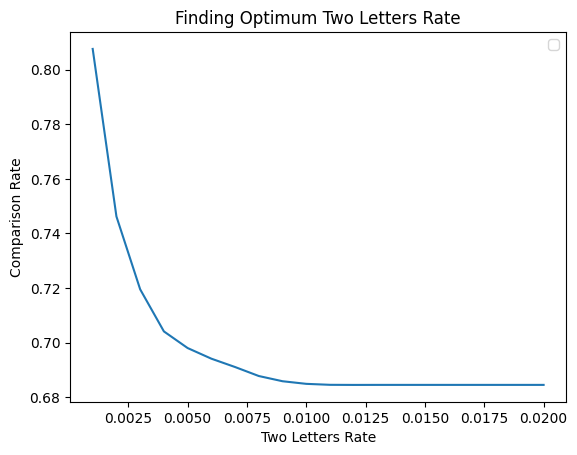

In [45]:
plt.plot(df3.index, df3['comparison_rate'])

plt.xlabel('Two Letters Rate')
plt.ylabel('Comparison Rate')
plt.title('Finding Optimum Two Letters Rate')

plt.legend()
plt.show()

array([[<Axes: title={'center': 'rate'}>,
        <Axes: title={'center': 'comparison_rate'}>],
       [<Axes: title={'center': 'compress_time'}>,
        <Axes: title={'center': 'decompress_time'}>]], dtype=object)

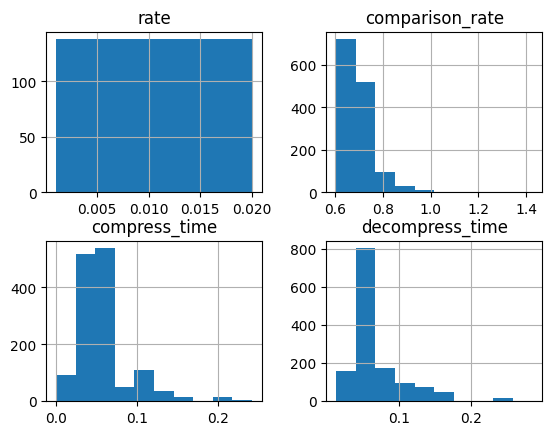

In [52]:
df.hist()

In [50]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
comparison_rate,20.0,0.698208,0.030046,0.684491,0.684503,0.684706,0.695084,0.807624
is_same,20.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
compress_time,20.0,0.055730,0.001025,0.053503,0.055267,0.055833,0.056271,0.058406
decompress_time,20.0,0.070586,0.001713,0.066930,0.069955,0.071029,0.071849,0.072659


In [16]:
compress_and_decompress("mahfiEgilmez", 0.005)

('mahfiEgilmez',
 0.005,
 0.6584228555031475,
 True,
 0.1266615390777588,
 0.15858817100524902)

In [17]:
compress_and_decompress("ridvanDilmen", 0.005)

('ridvanDilmen',
 0.005,
 0.6887779422464186,
 True,
 0.11691141128540039,
 0.13519549369812012)

In [18]:
compress_and_decompress("elifSafak", 0.005)

('elifSafak',
 0.005,
 0.6617674911928482,
 True,
 0.1047203540802002,
 0.36602139472961426)

In [19]:
compress_and_decompress("muratBardakci", 0.005)

('muratBardakci',
 0.005,
 0.6884520215205103,
 True,
 0.10048151016235352,
 0.18650031089782715)